# Livrable 3 - Captionning

Groupe 2 :
- Brenda DJIGUEMDE
- Bruno DIAS
- Dany KHADHAR
- Romaric DEMBELE

## Contexte

Ce livrable marque l'achèvement de notre processus de traitement. Notre objectif est de développer un réseau de neurones capable de générer des légendes pour des images, en utilisant le dataset `MS COCO` comme base. Le réseau se compose de deux éléments principaux : une partie Convolutional Neural Network (CNN) qui encode les images en une représentation interne, et une partie Recurrent Neural Network (RNN) qui utilise cette représentation pour prédire la légende de l'image, séquence par séquence. Avant l'entraînement du modèle, les images sont prétraitées par un CNN pré-entraîné pour la classification.

## 1. Imports

Nous commencons par importer les différentes librairies nécessaires.

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import numpy as np
import os
import json
from glob import glob
from tqdm import tqdm
import time
from collections import defaultdict
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from pycocoevalcap.cider.cider import Cider
import nltk


## 2. Chargement des données

Nous préparons notre ensemble de données pour l'entraînement de notre modèle de génération de légendes. Nous commençons par définir les chemins vers le fichier d'annotations et le dossier contenant les images à annoter. Ensuite, nous lisons le fichier d'annotations et regroupons toutes les annotations ayant la même image comme identifiant. Pour chaque annotation, nous marquons le début et la fin de chaque légende et ajoutons cette légende à la liste des légendes associées à l'image correspondante. Nous limitons ensuite notre ensemble de données aux 2000 premières images afin de réduire la puissance de calcul nécessaire à l'entraînement de notre modèle. L'utilisation de plus de données améliorerait la qualité du sous-titrage, cependant, nos machines n'étant pas suffisament performantes, nous ne pouvons pas nous permettre d'augmenter notre jeu d'entraînement. Enfin, nous créons deux listes : une contenant toutes les légendes et une autre contenant les noms des fichiers images, chaque path étant répété autant de fois qu'il y a de légendes associées à cette image. Ces listes seront utilisées pour l'entraînement de notre modèle.

In [4]:
#Chemin du fichier d'annotations
annotation_folder = "/dataset_livrable_3/annotations/"
annotation_file = os.path.abspath('.')+"/dataset_livrable_3/annotations/captions_train2014.json"

#Chemin du dossier contenant les images à annoter
image_folder = '/dataset_livrable_3/train2014/'
PATH = os.path.abspath('.') + image_folder

#Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

#Groupe toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    #Marque le debut et la fin de chaque annotation
    caption = f"<start> {val['caption']} <end>"
    #L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    #Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)

#Prend les 2000 premières images
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:2000]

#Liste de toutes les annotations
train_captions = []
#Liste de tous les noms de fichiers des images
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    #Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    #Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))

Vérifions si chaque annotations comprends bien une image qui lui ai associée.

In [5]:
print(len(train_captions))
print(len(img_name_vector))

10005
10005


Visualisons les neuf premières images de notre ensemble de données, accompagnées de leurs annotations respectives. Pour ce faire, nous avons regroupé les légendes par chemin d'image à l'aide d'un dictionnaire. Ensuite, nous parcourons ce dictionnaire et pour chaque image, nous affichons l'image elle-même suivie de toutes ses légendes correspondantes. Cette visualisation nous permet d'avoir une meilleure compréhension des données sur lesquelles nous travaillons.

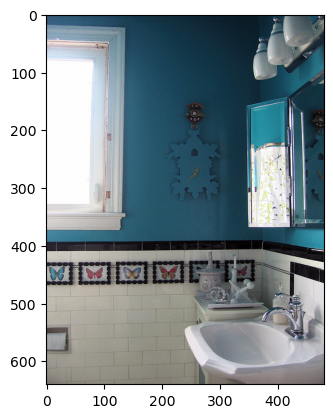

<start> A very clean and well decorated empty bathroom <end>
<start> A blue and white bathroom with butterfly themed wall tiles. <end>
<start> A bathroom with a border of butterflies and blue paint on the walls above it. <end>
<start> An angled view of a beautifully decorated bathroom. <end>
<start> A clock that blends in with the wall hangs in a bathroom.  <end>


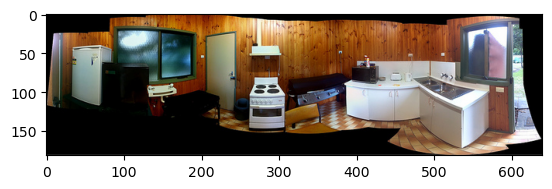

<start> A panoramic view of a kitchen and all of its appliances. <end>
<start> A panoramic photo of a kitchen and dining room <end>
<start> A wide angle view of the kitchen work area <end>
<start> multiple photos of a brown and white kitchen.  <end>
<start> A kitchen that has a checkered patterned floor and white cabinets. <end>


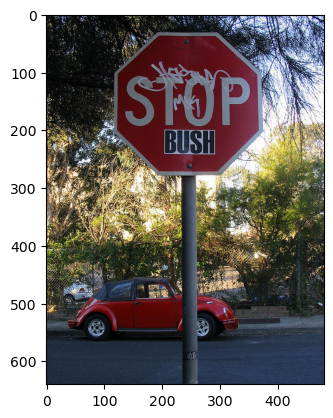

<start> A graffiti-ed stop sign across the street from a red car  <end>
<start> A vandalized stop sign and a red beetle on the road <end>
<start> A red stop sign with a Bush bumper sticker under the word stop. <end>
<start> A stop sign that has been vandalized is pictured in front of a parked car. <end>
<start> A street sign modified to read stop bush. <end>


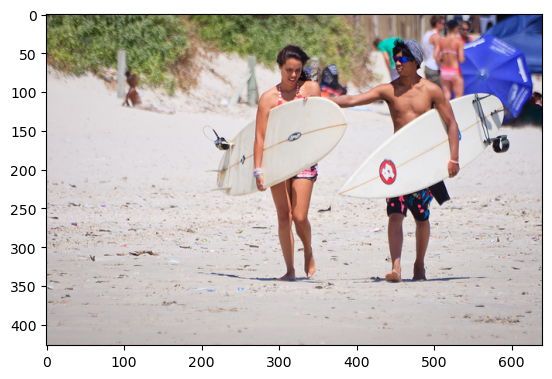

<start> The two people are walking down the beach. <end>
<start> Two people carrying surf boards on a beach. <end>
<start> Two teenagers at a white sanded beach with surfboards. <end>
<start> A couple at the beach walking with their surf boards. <end>
<start> A guy and a girl are walking on the beach holding surfboards. <end>


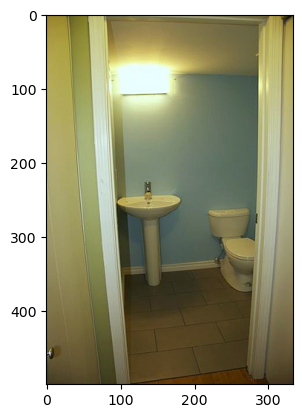

<start> A sink and a toilet inside a small bathroom. <end>
<start> White pedestal sink and toilet located in a poorly lit bathroom. <end>
<start> Clean indoor bathroom with tiled floor and good lighting. <end>
<start> a bathroom with toilet and sink and blue wall <end>
<start> a blue bathroom with a sink and toilet <end>


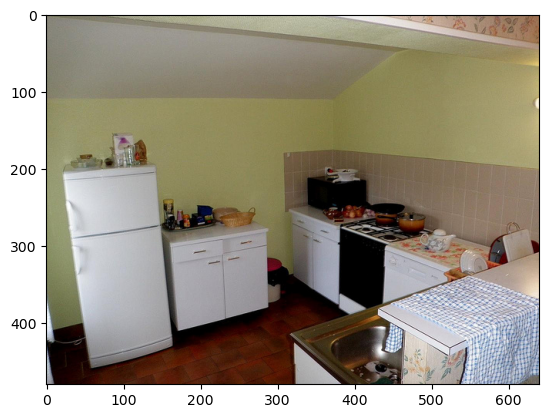

<start> An empty kitchen with white and black appliances. <end>
<start> A refrigerator and stove are in a small kitchen area.  <end>
<start> Small kitchen in a personal home with dual sinks. <end>
<start> A small kitchen with sink, stove and refrigerator. <end>
<start> A small kitchen with several appliances and cookware. <end>


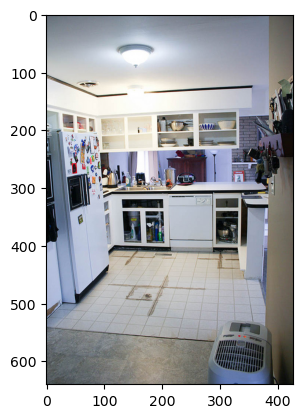

<start> A white square kitchen with tile floor that needs repairs  <end>
<start> A white kitchen in a home with the light on. <end>
<start> A kitchen with a tile floor has cabinets with no doors, a dishwasher, a sink, and a refrigerator. <end>
<start> A white kitchen without doors on the cabinets. <end>
<start> A white kitchen filled with pots, pans and dishes. <end>


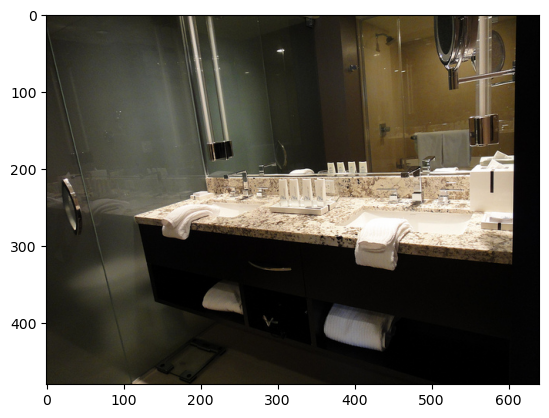

<start> The vanity contains two sinks with a towel for each. <end>
<start> A clean restroom with towels and washcloths laid out. <end>
<start> The bathroom counter is stocked with towels and supplies. <end>
<start> There is a clean bathroom counter and sink. <end>
<start> A hotel bathroom with stone counter and mirror <end>


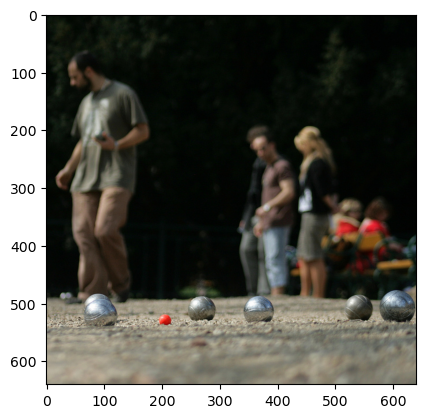

<start> Several metal balls sit in the sand near a group of people. <end>
<start> People standing around many silver round balls on the ground. <end>
<start> Silver balls are lined up in the sand as people mill about in the background. <end>
<start> Silver balls on sand with people walking around.  <end>
<start> silver balls laying on the ground around a smaller red ball.  <end>


In [6]:
#Crée un dictionnaire pour regrouper les légendes par chemin d'image
captions_by_image = defaultdict(list)
for img_path, caption in zip(img_name_vector, train_captions):
    captions_by_image[img_path].append(caption)

#Affiche les 9 premières images avec toutes leurs légendes
images_displayed = 0
for img_path, captions in captions_by_image.items():
    if images_displayed < 9:
        image = Image.open(img_path)
        plt.imshow(image)
        plt.show()

        #Affiche toutes les légendes pour cette image
        for caption in captions:
            print(caption)
        images_displayed += 1
    else:
        break

## 3. Pré-traitement des images



L'étape du prétraitement des images comprend le redimensionnement des images, la normalisation des pixels et l'application de transformations. Elle prépare nos données pour un traitement efficace et optimise les performances du modèle. Nous utilisons des modèles pré-entraînés pour extraire des caractéristiques pertinentes de nos images. Cela nous permet de convertir nos images en un format adapté à notre modèle de captioning, tout en conservant les informations visuelles essentielles. Cette approche s'appelle `transfer learning`, où nous exploitons les connaissances d'un modèle pour résoudre une autre tâche.

### Télechargement des modèles

Nous avons choisi de tester trois modèles de base différents : `InceptionV3`, `ResNet50` et `EfficientNetB0`. Ces modèles sont pré-entraînés sur ImageNet et sont utilisés sans leur couche supérieure pour permettre l'extraction des caractéristiques. Nous avons une fonction pour charger et prétraiter les images. Cette fonction lit l'image à partir d'un chemin donné, la décode en un tensor JPEG à 3 canaux, redimensionne l'image à la taille appropriée pour le modèle choisi et applique le prétraitement approprié pour le modèle.

In [7]:
def create_image_features_model(model_name):
    base_models = {
        'InceptionV3': tf.keras.applications.InceptionV3,
        'ResNet50': tf.keras.applications.ResNet50,
        'EfficientNetB0': tf.keras.applications.EfficientNetB0
    }
    if model_name not in base_models:
        raise ValueError("Modèle non supporté.")
    image_model = base_models[model_name](include_top=False, weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output
    return tf.keras.Model(new_input, hidden_layer)

def load_image(image_path, model_name):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    if model_name == 'InceptionV3':
        img = tf.image.resize(img, (299, 299))
        img = tf.keras.applications.inception_v3.preprocess_input(img)
    elif model_name == 'ResNet50':
        img = tf.image.resize(img, (224, 224))
        img = tf.keras.applications.resnet.preprocess_input(img)
    elif model_name == 'EfficientNetB0':
        img = tf.image.resize(img, (224, 224))
        img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, image_path

### Extraction et sauvegarde des caractéristiques d'images avec InceptionV3

Dans notre modèle de base, nous utiliserons `InceptionV3` pour extraire les caractéristiques de nos images. InceptionV3 est un réseau de neurones convolutifs (CNN) qui a été pré-entraîné sur un vaste ensemble de données d'images, tel que l'ensemble de données ImageNet, ce qui lui permet d'apprendre des représentations de haut niveau des images. 

Nous testerons plutard d'autres modèles comme `ResNet` et `EfficientNet` pour déterminer celui qui est plus adapté à notre cas.

In [8]:
# Prepare the dataset
model_name = 'InceptionV3'
encode_train = sorted(set(img_name_vector))  

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    lambda x: load_image(x, model_name), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

def extract_features_and_save(image_dataset, image_features_extract_model):
    for img, path in tqdm(image_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())

image_features_extract_model = create_image_features_model(model_name)
extract_features_and_save(image_dataset, image_features_extract_model)

100%|██████████| 125/125 [03:20<00:00,  1.61s/it]


## 4. Prétraitement des annotations

Préparons nos légendes pour l'entraînement du modèle. Nous commençons par définir une fonction pour calculer la longueur maximale des légendes. Ensuite, nous utilisons la classe Tokenizer de TensorFlow pour convertir nos légendes en séquences de tokens. Nous limitons notre vocabulaire aux 5000 mots les plus fréquents et nous introduisons un token spécial "\<unk\>" pour tous les mots inconnus. Nous ajoutons également un token de remplissage "" pour égaliser la longueur de toutes les séquences. Ensuite, nous transformons nos légendes en séquences de tokens et nous les remplissons jusqu'à la longueur maximale. Enfin, nous calculons la longueur maximale des séquences, qui sera utilisée plus tard pour stocker les poids d'attention lors de l'évaluation du modèle.

In [9]:
#Trouve la taille maximale
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

#Choisit les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
#Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(\
    train_captions)

#Crée le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

#Creation de vecteurs (liste de token entiers) à partir des annotations (liste de mots)
train_seqs = \
    tokenizer.texts_to_sequences(train_captions)

#Remplit chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = \
    tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

In [10]:
#Affichage
print(train_seqs[0])
print(train_captions[0])
train_seqs

[3, 2, 87, 76, 6, 301, 191, 124, 11, 4]
<start> A very clean and well decorated empty bathroom <end>


[[3, 2, 87, 76, 6, 301, 191, 124, 11, 4],
 [3, 2, 70, 6, 16, 11, 5, 2484, 928, 60, 240, 4],
 [3, 2, 11, 5, 2, 2485, 9, 2486, 6, 70, 633, 10, 8, 111, 133, 47, 4],
 [3, 18, 2487, 97, 9, 2, 1848, 191, 11, 4],
 [3, 2, 807, 54, 2488, 7, 5, 8, 60, 706, 7, 2, 11, 4],
 [3, 2, 1302, 97, 9, 2, 12, 6, 161, 9, 364, 72, 4],
 [3, 2, 1302, 101, 9, 2, 12, 6, 175, 55, 4],
 [3, 2, 552, 1303, 97, 9, 8, 12, 428, 79, 4],
 [3, 414, 600, 9, 2, 98, 6, 16, 12, 4],
 [3, 2, 12, 54, 37, 2, 707, 929, 65, 6, 16, 57, 4],
 [3, 2, 759, 2489, 246, 168, 263, 8, 29, 102, 2, 73, 52, 4],
 [3, 2, 1540, 246, 168, 6, 2, 73, 1849, 10, 8, 120, 4],
 [3, 2, 73, 246, 168, 5, 2, 1850, 930, 808, 103, 8, 1851, 246, 4],
 [3, 2, 246, 168, 54, 37, 264, 1540, 13, 1304, 7, 49, 9, 2, 50, 52, 4],
 [3, 2, 29, 168, 1852, 17, 1305, 246, 1850, 4],
 [3, 8, 21, 24, 32, 71, 41, 8, 145, 4],
 [3, 21, 24, 282, 335, 708, 10, 2, 145, 4],
 [3, 21, 2490, 27, 2, 16, 2491, 145, 5, 634, 4],
 [3, 2, 164, 27, 8, 145, 71, 5, 113, 335, 708, 4],
 [3, 2, 342, 6, 

In [11]:
cap_vector

array([[ 3,  2, 87, ...,  0,  0,  0],
       [ 3,  2, 70, ...,  0,  0,  0],
       [ 3,  2, 11, ...,  0,  0,  0],
       ...,
       [ 3,  8, 20, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0]])

## 5. Jeux de données

Pour préparer les données pour l'entraînement et la validation, nous créons d'abord un dictionnaire associant chaque image à ses annotations. Les données sont par la suite divisées en ensembles d'entraînement et de validation avec une répartition de 80-20. Les images sont dupliquées en fonction du nombre d'annotations correspondantes pour construire les ensembles d'entraînement et de validation. À la fin, nous obtenons quatre listes : `img_name_train`, `cap_train pour l'entraînement` et `img_name_val`, `cap_val` pour la validation.

In [12]:
def create_img_to_cap_vector(img_name_vector, cap_vector):
    img_to_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_vector, cap_vector):
        img_to_cap_vector[img].append(cap)
    return img_to_cap_vector

def prepare_datasets(img_to_cap_vector, split_ratio=0.8):
    img_keys = list(img_to_cap_vector.keys())
    random.shuffle(img_keys)
    slice_index = int(len(img_keys) * split_ratio)
    img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

    img_name_train, cap_train = [], []
    for img in img_name_train_keys:
        cap_list = img_to_cap_vector[img]
        img_name_train.extend([img] * len(cap_list))
        cap_train.extend(cap_list)

    img_name_val, cap_val = [], []
    for img in img_name_val_keys:
        cap_list = img_to_cap_vector[img]
        img_name_val.extend([img] * len(cap_list))
        cap_val.extend(cap_list)

    return (img_name_train, cap_train), (img_name_val, cap_val)

img_to_cap_vector = create_img_to_cap_vector(img_name_vector, cap_vector)
(img_name_train, cap_train), (img_name_val, cap_val) = prepare_datasets(img_to_cap_vector)

En partant du jeu de données de base (les noms des fichiers et des annotations du jeu d’entrainement) nous utilisons la classe `tf.data.Dataset` qui sert à représenter des jeux de données volumineux et facilitent les prétraitements de ceux-ci.

Nous définissons d'abord plusieurs paramètres pour notre modèle, tels que la taille du batch, la taille du buffer pour mélanger les données, la dimension de l'embedding, la taille de la couche cachée dans le RNN, la taille du vocabulaire et le nombre d'étapes. Nous spécifions également la forme du vecteur extrait à partir d'InceptionV3.

Ensuite, nous définissons une fonction map_func qui charge les fichiers numpy des images prétraitées.

Nous créons un dataset de tensors à partir de nos données d'entraînement, puis nous utilisons la fonction map pour charger les fichiers numpy en parallèle.

Enfin, nous mélangeons les données, les divisons en batchs et préchargeons les prochains éléments pour améliorer les performances.

In [13]:
EPOCHS = 2 #Nombre d'epochs
BATCH_SIZE = 64 #Taille du batch
BUFFER_SIZE = 1000 #Taille du buffer pour melanger les donnes
embedding_dim = 256 #Taille de l'embedding
units = 512 #Taille de la couche caché dans le RNN
vocab_size = top_k + 1 #Taille du vocabulaire
num_steps = len(img_name_train) // BATCH_SIZE #Nombre de pas par epoch

#La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
#Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

#Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

def load_and_process_data(img_name_list, cap_list):
    dataset = tf.data.Dataset.from_tensor_slices((img_name_list, cap_list))
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
              map_func, [item1, item2], [tf.float32, tf.int32]),
              num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

## 6. Modèle

Notre modèle combine un Convolutional Neural Networks (CNN) et un Recurrent Neural Networks (RNN) utilisant les forces de ces deux types de réseaux de neurones pour traiter nos données. Le CNN est utilisé pour extraire des caractéristiques spatiales à partir d'images grâce à ses couches de convolution. Ces caractéristiques sont ensuite transmises au réseau RNN, qui est capable de gérer des séquences de données et de capturer des dépendances temporelles grâce à ses états cachés.

### L'encodeur CNN

Dans ce bloc de code, nous définissons une classe `CNN_Encoder` qui est un encodeur pour notre modèle. Comme nos images sont déjà prétraitées par InceptionV3 et représentées sous une forme compacte, notre encodeur CNN se contente de passer ces caractéristiques à travers une couche dense. La méthode `call()` de cette classe applique la couche dense à l'entrée x et passe ensuite le résultat à travers une fonction d'activation ReLU.

In [14]:
@tf.keras.utils.register_keras_serializable()
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()

        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)  # Applique une transformation Dense
        x = tf.nn.relu(x)  # Applique une activation ReLU
        return x

### Le mécanisme d'attention : la classe Bahdanau


Le mécanisme d'attention, spécifiquement l'attention de Bahdanau, est un concept utilisé en apprentissage profond pour améliorer la précision des modèles en leur permettant de se concentrer sur des parties spécifiques des données d'entrée. Dans notre contexte de traitement d'image, l'image est divisée en plusieurs zones, chacune contenant des informations sur une partie de l'image. Le modèle calcule un score d'attention pour chaque zone, indiquant l'importance de cette zone pour la prédiction suivante. Ces scores sont transformés en pourcentages à l'aide d'une fonction softmax, assurant que tous les pourcentages s'additionnent à 100%. Le modèle utilise ensuite ces pourcentages pour créer un vecteur de contexte, qui est une combinaison pondérée des informations de toutes les zones de l'image. Ce vecteur de contexte est utilisé pour choisir le mot suivant à prédire. L'attention permet au modèle d'être précis sur quelle partie de l'image il décrit à chaque instant, et offre la flexibilité de revenir sur des parties de l'image qu'il pourrait avoir besoin de décrire plus en détail après avoir introduit d'autres éléments.

In [15]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features)+self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights =  tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

### Décodeur RNN

Nous introduisons la classe `RNN_Decoder` qui est un décodeur RNN dans notre modèle. Elle utilise une couche d'embedding, une couche GRU et deux couches denses pour générer la légende de l'image. Elle utilise également le mécanisme d'attention de Bahdanau pour se concentrer sur différentes parties de l'image lors de la génération de la légende. La méthode call de cette classe effectue le processus de décodage, tandis que la méthode reset_state est utilisée pour réinitialiser l'état du GRU à zéro.

In [16]:
@tf.keras.utils.register_keras_serializable()
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = \
                tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        #Couche dense qui aura pour entrée la sortie du GRU
        self.fc1 = \
            tf.keras.layers.Dense(self.units)
        # Dernière couche dense
        self.fc2 = \
                tf.keras.layers.Dense(vocab_size)

        self.attention = \
                BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        try:
            # Attention layer processing
            context_vector, attention_weights = self.attention(features, hidden)

            # Embedding input words
            x = self.embedding(x)

            # Concatenating context vector to the embedded input
            x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

            # GRU processing
            output, state = self.gru(x, initial_state=hidden)
            # Dense layer processing on the output of GRU
            y = self.fc1(output)
            # Reshaping y for the final Dense layer (fc2)
            y = tf.reshape(y, (-1, y.shape[2]))
            # Final output prediction
            y = self.fc2(y)

            return y, state, attention_weights
        except Exception as e:
            print("Error during model call:", e)
            raise

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

Nous instancions nos classes d'encodeur et de décodeur. 

In [17]:
# Création de l'encodeur
encoder = \
    CNN_Encoder(embedding_dim)
# Création du décodeur
decoder = \
    RNN_Decoder(embedding_dim, units, vocab_size)

Nous définissons l'optimiseur et la fonction de perte pour notre modèle. Nous utilisons l'optimiseur Adam, qui est une méthode de descente de gradient stochastique largement utilisée pour les réseaux de neurones profonds. Ensuite, nous définissons notre fonction de perte comme étant la cross-entropie catégorielle sparse. Nous utilisons également un masque pour ignorer les pertes calculées pour les séquences de padding. La fonction loss_function calcule la perte moyenne sur toutes les instances non masquées.

In [18]:
# Optimiseur ADAM
optimizer = \
    tf.keras.optimizers.Adam()
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

loss_plot = []

### Checkpoint 

Nous mettons en place un système de sauvegarde récuperer le model le plus performent lors de l'entrainement. Nous définissons d'abord le chemin où les points de contrôle seront stockés. Ensuite, nous créons un objet Checkpoint qui enregistre l'état de l'encodeur, du décodeur. Enfin, nous créons un CheckpointManager qui gère la sauvegarde et la restauration des points de contrôle, et qui ne conserve que les 5 derniers points de contrôle.

In [19]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [20]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## 7. Entrainement et tests

### Entrainement

Nous définissons une fonction d'entraînement pour notre modèle. Nous initialisons d'abord la perte à zéro et l'état caché du décodeur. Ensuite, nous définissons l'entrée du décodeur pour être le mot de début de séquence pour chaque exemple dans le batch. À l'intérieur d'un bloc `tf.GradientTape`, nous passons l'image à travers l'encodeur pour obtenir les caractéristiques. Pour chaque mot dans la cible, nous faisons une prédiction avec le décodeur, calculons la perte et mettons à jour l'entrée du décodeur pour être le mot cible correct. Après avoir calculé la perte totale, nous obtenons les gradients de la perte par rapport aux variables entraînables et appliquons ces gradients à l'aide de l'optimiseur. Enfin, nous retournons la perte et la perte totale.

In [21]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Update decoder input
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Fonction pour effectuer l'entraînement de notre modèle sur un nombre défini d'époques. 

Error during model call: Exception encountered when calling BahdanauAttention.call().

'tensorflow.python.framework.ops.EagerTensor' object has no attribute '_serialize_to_tensors'

Arguments received by BahdanauAttention.call():
  • features=tf.Tensor(shape=(64, 64, 256), dtype=float32)
  • hidden=tf.Tensor(shape=(64, 512), dtype=float32)


c:\Users\brend\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:583: UserWarning: Gradients do not exist for variables ['kernel', 'kernel', 'kernel', 'bias', 'kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1 Batch 0 Loss 1.6366
Epoch 1 Batch 100 Loss 0.5691
Epoch 1 Loss 0.734989
Time taken for 1 epoch 585.3139028549194 sec

Epoch 2 Batch 0 Loss 0.4374
Epoch 2 Batch 100 Loss 0.3452
Epoch 2 Loss 0.396272
Time taken for 1 epoch 626.2533016204834 sec



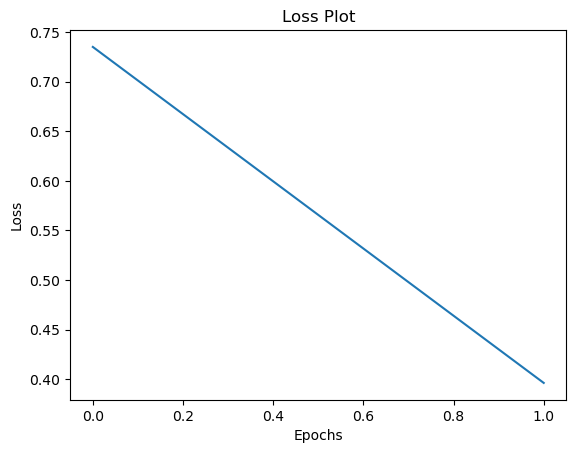

In [22]:
def train_epochs(dataset, start_epoch, num_steps, EPOCHS):

    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(
                    epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        # Sauvegarde de la perte
        loss_plot.append(total_loss / num_steps)

        if epoch % 5 == 0:
            ckpt_manager.save()

        print('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                            total_loss / num_steps))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    # Affichage de la courbe d'entraînement
    plt.plot(loss_plot)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.show()

start_epoch=0
train_dataset = load_and_process_data(img_name_train, cap_train)
train_epochs(train_dataset, start_epoch, num_steps, EPOCHS)

In [25]:
#Sauvegarde
encoder.save('captioner_encoder.keras')
decoder.save('captioner_decoder.keras')

### Tests

Testons notre modèle avec la fonction `evaluate()` qui prend une image en entrée, la pré-traite et l'encode en utilisant notre modèle d'encodeur. Elle décode l'image en une séquence de mots en utilisant le décodeur, tout en gardant une trace des poids d'attention pour chaque mot prédit. La fonction renvoie la séquence de mots prédite et les poids d'attention correspondants. La fonction plot_attention prend une image, une séquence de mots et des poids d'attention en entrée, et affiche l'image avec les poids d'attention superposés pour chaque mot de la séquence. Cela nous permet de visualiser où le modèle porte son attention lorsqu'il génère chaque mot.

In [24]:
nltk.download('wordnet')

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image, model_name)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

ModuleNotFoundError: No module named 'rouge'

Sélectionnons une image aléatoire de notre ensemble de validation et testons.

Nous utilisons les métriques `METEOR`, `ROUGE (Recall-Oriented Understudy for Gisting Evaluation)` et `CIDEr (Consensus-based Image Description Evaluation)` pour évaluer la qualité des légendes générées par les modèles de génération de légendes d'images.

`METEOR` mesure la similarité entre les légendes générées et les légendes de référence en tenant compte de la précision et du rappel. Elle évalue à la fois la précision des mots et la similarité sémantique. Une valeur METEOR élevée indique une meilleure correspondance entre les légendes générées et les références.

`ROUGE` évaluent la similarité entre les légendes générées et les légendes de référence en mesurant le rappel (recall) des n-grammes (mots ou séquences de mots). 

`CIDEr` mesure la qualité des légendes générées en tenant compte de la diversité et de la cohérence des descriptions. Elle évalue à la fois la précision des mots et la variance des expressions. Une valeur CIDEr élevée indique une meilleure qualité et une plus grande variété dans les légendes générées.

Prédiction:  a bicycle leaning against a wall with a knife in the background <end>
Réelle:  <start> a bicycle on a sidewalk leans against a wall <end>
Score METEOR:  0.5636160714285714
Scores ROUGE:  [{'rouge-1': {'r': 0.5555555555555556, 'p': 0.45454545454545453, 'f': 0.4999999950500001}, 'rouge-2': {'r': 0.3, 'p': 0.25, 'f': 0.27272726776859507}, 'rouge-l': {'r': 0.5555555555555556, 'p': 0.45454545454545453, 'f': 0.4999999950500001}}]
Score CIDEr:  [0.]


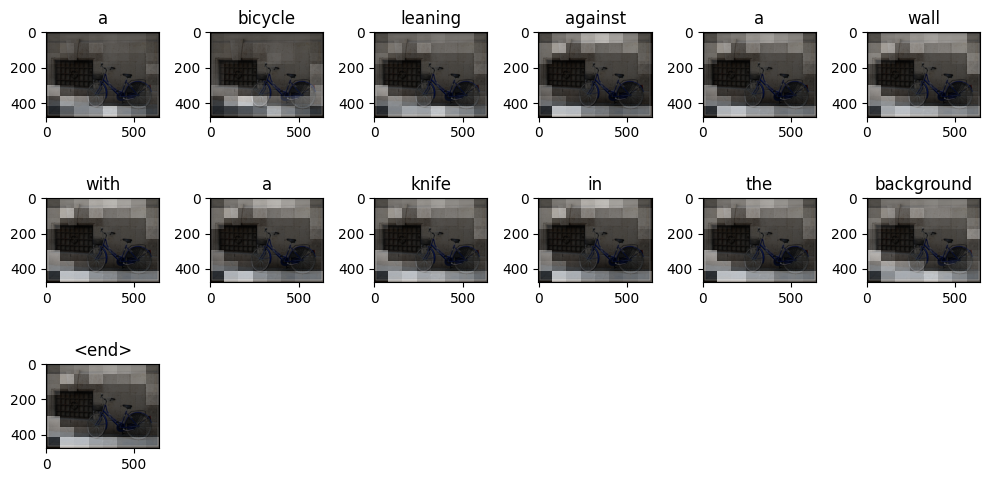

In [ ]:
def calculate_metrics(predicted_caption, real_caption):
    reference = [real_caption.split()]
    candidate = predicted_caption.split()
    meteor = meteor_score(reference, candidate)
    rouge = Rouge().get_scores(predicted_caption, real_caption)
    cider = Cider()
    cider_score = cider.compute_score({1: [real_caption]}, {1: [predicted_caption]})
    return meteor, rouge, cider_score[1]

# Utilisation des fonctions
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
predicted_caption, attention_plot = evaluate(image)
meteor, rouge_scores, cider_score = calculate_metrics(' '.join(predicted_caption), real_caption)

print("Prédiction: ", ' '.join(predicted_caption))
print("Réelle: ", real_caption)
print("Score METEOR: ", meteor)
print("Scores ROUGE: ", rouge_scores)
print("Score CIDEr: ", cider_score)

plot_attention(image, predicted_caption, attention_plot)

Il semble que le modèle produise une prédiction raisonnable, mais avec quelques différences par rapport à la véritable légende. Voici quelques observations sur la prédiction par rapport à la légende réelle :

La prédiction comprend les éléments principaux de la scène : un bus et des vélos sur une rue.
Cependant, la prédiction contient quelques erreurs mineures :
La prédiction mentionne des personnes attendant le bus, ce qui n'est pas présent dans la légende réelle.
La prédiction utilise une formulation différente pour décrire la scène, mais le sens général est similaire.

## Test de performance des modèles Resnet50 et EfficientNetB0

### Model ResNet50

`ResNet (Residual Networks)` est une architecture de CNN profonde qui a été très performante sur diverses tâches de vision par ordinateur. `ResNet-50` est une version pré-entraînée de ResNet sur des ensembles de données massifs comme ImageNet. Il peut être utilisé pour extraire des caractéristiques visuelles riches des images MS COCO.

In [ ]:
# Préparer les données pour ResNet50
model_name = 'ResNet50'
image_features_extract_model_resnet50 = create_image_features_model(model_name)

# Créer le dataset pour ResNet50
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    lambda x: load_image(x, model_name), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Extraire les caractéristiques en utilisant ResNet50
extract_features_and_save(image_dataset, image_features_extract_model_resnet50)

# Création de vecteurs image-annotation et préparation des datasets
img_to_cap_vector = create_img_to_cap_vector(img_name_vector, cap_vector)
(img_name_train, cap_train), (img_name_val, cap_val) = prepare_datasets(img_to_cap_vector)

# Préparer le dataset d'entraînement (assumant que le dataset est mis à jour pour utiliser les fichiers .npy de ResNet50)
train_dataset = load_and_process_data(img_name_train, cap_train)

# Réinitialiser les paramètres d'entraînement et le modèle
loss_plot = []
start_epoch = 0
num_steps = len(img_name_train) // BATCH_SIZE

# Appel de la fonction d'entraînement
train_epochs(train_dataset, start_epoch, num_steps, EPOCHS)

 27%|██▋       | 34/125 [00:33<01:33,  1.02s/it]

Prédiction:  a man and man on a bicycle walk <end>
Réelle:  <start> two people are laughing while looking at a picture on a cell phone <end>
Score METEOR:  0.2191840277777778
Scores ROUGE:  [{'rouge-1': {'r': 0.21428571428571427, 'p': 0.42857142857142855, 'f': 0.28571428126984133}, 'rouge-2': {'r': 0.07142857142857142, 'p': 0.125, 'f': 0.09090908628099197}, 'rouge-l': {'r': 0.21428571428571427, 'p': 0.42857142857142855, 'f': 0.28571428126984133}}]
Score CIDEr:  [0.]


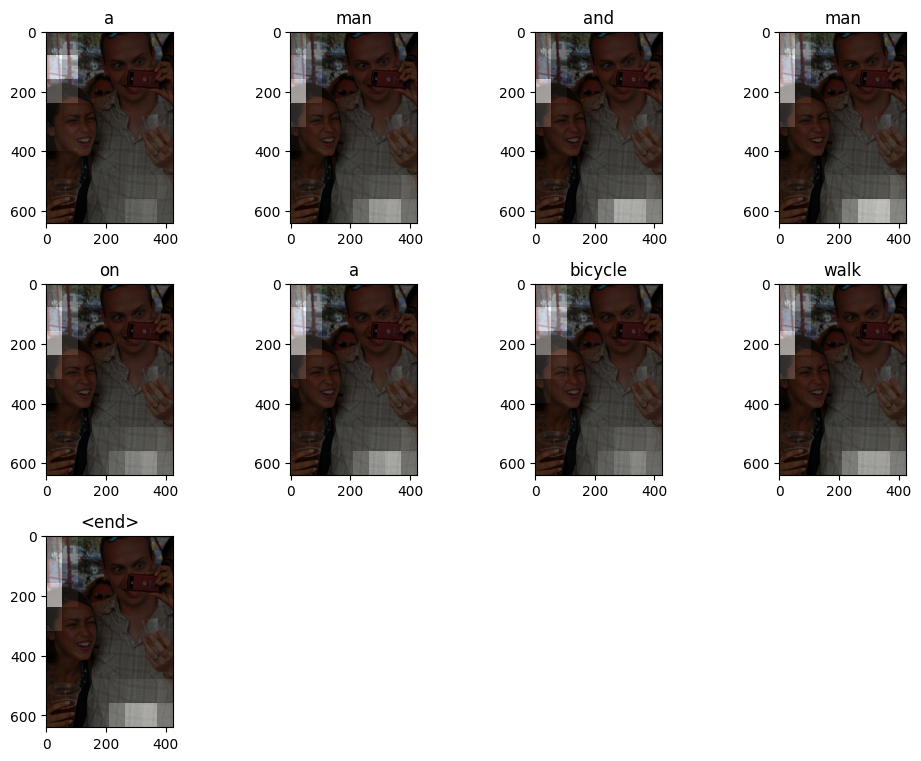

In [ ]:
#Appel de la fonction evaluate
attention_features_shape=25
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
predicted_caption, attention_plot = evaluate(image)
meteor, rouge_scores, cider_score = calculate_metrics(' '.join(predicted_caption), real_caption)

print("Prédiction: ", ' '.join(predicted_caption))
print("Réelle: ", real_caption)
print("Score METEOR: ", meteor)
print("Scores ROUGE: ", rouge_scores)
print("Score CIDEr: ", cider_score)

plot_attention(image, predicted_caption, attention_plot)

### Model EfficientNetB0

`EfficientNet` est une famille d'architectures CNN qui ont été conçues pour être à la fois précises et efficaces en termes de calcul. Ces modèles ont été pré-entraînés sur ImageNet et peuvent être utilisés pour extraire des caractéristiques visuelles des images MS COCO avec un bon compromis entre la précision et la vitesse de traitement. `EfficientNetB0` en est une version.

100%|██████████| 125/125 [03:54<00:00,  1.88s/it]
c:\Users\danyk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'kernel', 'bias', 'kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1 Batch 0 Loss 1.2901
Epoch 1 Batch 100 Loss 0.7642
Epoch 1 Loss 0.762369
Time taken for 1 epoch 473.42468190193176 sec

Epoch 2 Batch 0 Loss 0.6273
Epoch 2 Batch 100 Loss 0.5523
Epoch 2 Loss 0.627954
Time taken for 1 epoch 413.97903871536255 sec



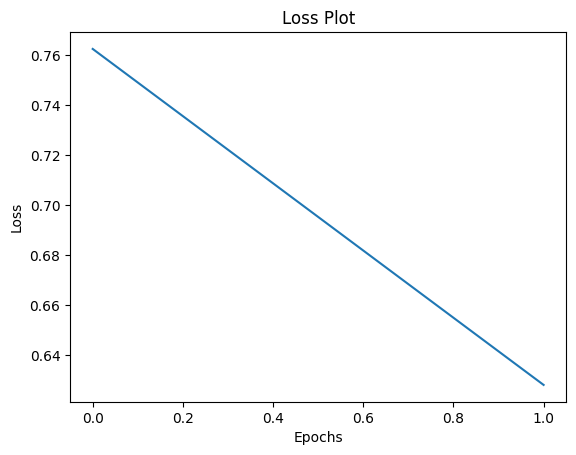

In [ ]:
# Initialisation du modèle pour EfficientNetB0
model_name = 'EfficientNetB0'
image_features_extract_model_EfficientNetB0 = create_image_features_model(model_name)

# Préparation des chemins d'image pour le traitement
encode_train = sorted(set(img_name_vector))  # Assurez-vous que img_name_vector est déjà défini
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    lambda x: load_image(x, model_name), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Extraction et sauvegarde des caractéristiques
extract_features_and_save(image_dataset, image_features_extract_model_EfficientNetB0)

# Création de vecteurs image-annotation et préparation des datasets
img_to_cap_vector = create_img_to_cap_vector(img_name_vector, cap_vector)
(img_name_train, cap_train), (img_name_val, cap_val) = prepare_datasets(img_to_cap_vector)

# Chargement et traitement des données d'entraînement
train_dataset = load_and_process_data(img_name_train, cap_train)

# Réinitialiser les paramètres d'entraînement et le modèle
loss_plot = []
start_epoch = 0
num_steps = len(img_name_train) // BATCH_SIZE
# Configuration et démarrage de l'entraînement
train_epochs(train_dataset, start_epoch, num_steps, EPOCHS)

In [ ]:
#Appel de la fonction evaluate
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
predicted_caption, attention_plot = evaluate(image)
meteor, rouge_scores, cider_score = calculate_metrics(' '.join(predicted_caption), real_caption)

print("Prédiction: ", ' '.join(predicted_caption))
print("Réelle: ", real_caption)
print("Score METEOR: ", meteor)
print("Scores ROUGE: ", rouge_scores)
print("Score CIDEr: ", cider_score)

plot_attention(image, predicted_caption, attention_plot)

ValueError: Exception encountered when calling CNN_Encoder.call().

[1mInput 0 of layer "dense_32" is incompatible with the layer: expected axis -1 of input shape to have value 2048, but received input with shape (1, 81, 1280)[0m

Arguments received by CNN_Encoder.call():
  • x=tf.Tensor(shape=(1, 81, 1280), dtype=float32)

## Création et sauvegarde du model 

In [ ]:
class FullImageCaptioningModel(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, tokenizer):
        super(FullImageCaptioningModel, self).__init__()
        self.tokenizer = tokenizer
        self.encoder = CNN_Encoder(embedding_dim)
        self.decoder = RNN_Decoder(embedding_dim, units, vocab_size)

    def call(self, img_tensor, cap):
        # Directly pass the image tensor to the encoder
        features = self.encoder(img_tensor)
        # Initialize the decoder state
        hidden = self.decoder.reset_state(batch_size=cap.shape[0])
        dec_input = tf.expand_dims([self.tokenizer.word_index['<start>']] * cap.shape[0], 1)
        
        loss = 0
        for i in range(1, cap.shape[1]):
            predictions, hidden, _ = self.decoder(dec_input, features, hidden)
            loss += loss_function(cap[:, i], predictions)
            # Use teacher forcing
            dec_input = tf.expand_dims(cap[:, i], 1)
        
        return loss

NameError: name 'tf' is not defined

In [ ]:
# Define a train step
def train_step(model, img_tensor, target, optimizer):
    print("Input shape to model:", img_tensor.shape)  # Check shape just before model usage
    loss = 0
    with tf.GradientTape() as tape:
        loss = model(img_tensor, target)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Train epochs function
import matplotlib.pyplot as plt

def train_epochs(model, dataset, start_epoch, num_epochs, num_steps, optimizer):
    epoch_losses = []  # Liste pour stocker les valeurs de perte par epoch
    for epoch in range(start_epoch, num_epochs):
        start = time.time()
        total_loss = 0
        for batch, (img_tensor, target) in enumerate(dataset):
            batch_loss = train_step(model, img_tensor, target, optimizer)
            total_loss += batch_loss.numpy()
            if batch % 100 == 0:
                print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1])}')
        epoch_loss = total_loss / num_steps
        epoch_losses.append(epoch_loss)  # Stocke la perte de l'epoch actuelle
        print(f'Epoch {epoch+1} Loss {epoch_loss}')
        print(f'Time taken for 1 epoch: {time.time() - start} sec')

    # Tracer la courbe de perte
    plt.plot(range(start_epoch, num_epochs), epoch_losses, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Load the model, prepare and process data, train the model
model_name = 'EfficientNetB0'
image_features_extract_model = create_image_features_model(model_name)
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    lambda x: load_image(x, model_name), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

def extract_features_and_save2(image_dataset, image_features_extract_model):
    for img, path in tqdm(image_dataset):
        batch_features = image_features_extract_model(img)
        # Flatten the features from (16, 7, 7, 1280) to (16, 62720)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], 7, 7, 1280))      
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())


extract_features_and_save2(image_dataset, image_features_extract_model)

img_to_cap_vector = create_img_to_cap_vector(img_name_vector, cap_vector)
(img_name_train, cap_train), (img_name_val, cap_val) = prepare_datasets(img_to_cap_vector)

# Create and train the FullImageCaptioningModel
full_model = FullImageCaptioningModel(
    embedding_dim=256,
    units=512,
    vocab_size=top_k + 1,
    tokenizer=tokenizer,
)

optimizer = tf.keras.optimizers.Adam()
train_dataset = load_and_process_data(img_name_train, cap_train)
train_epochs(full_model, train_dataset, 0, EPOCHS, num_steps, optimizer)

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Feature shape: (16, 7, 7, 1280)
Input shape to model: (64, 7, 7, 1280)
Input tensor shape: (64, 7, 7, 1280)
Encoded features shape: (64, 256)
Input tensor shape: (64, 7, 7, 1280)
Encoded features shape: (64, 256)
Epoch 1 Batch 0 Loss 2.8773269653320312
Input shape to model: (64, 7, 7, 1280)
Input tensor shape: (64, 7, 7, 1280)
Encoded features shape: (64, 256)
Input shape to model: (64, 7, 7, 1280)
Input tensor shape: (64, 7, 7, 1280)
Encoded features shape: (64, 256)
Input shape to model: (64, 7, 7, 1280)
Input tensor shape: (64, 7, 7, 1280)
Encoded features shape: (64, 256)
Input shape to model: (64, 7, 7, 1280)
Input tensor shape: (64, 7, 7, 1280)
Encoded features shape: (64, 256)
Input shape to model: (64, 7, 7, 1280)
Input tensor shape: (64, 7, 7, 1280)
Encoded features shape: (64, 256)
Input shape to model: (64, 7, 7, 1280)
Input tensor shape: (64, 7, 7, 1280)
Encoded features shape: (64, 256)
Input shape to model: (64, 7, 7, 1280)
Input tensor shape: (64, 7, 7, 1280)
Encoded fea

In [ ]:
def generate_caption(model, image_path, tokenizer):
    # Afficher l'image
    plt.imshow(image_path)
    plt.axis('off')
    plt.show()
    
    # Extraction des caractéristiques de l'image
    img_features = image_features_extract_model(tf.expand_dims(img, axis=0))
    # Prédiction de la légende
    predicted_caption = []
    hidden = None  # Réinitialisez l'état caché
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)  # Début de la séquence
    for i in range(max_length):
        predictions, hidden, _ = model.decoder(dec_input, img_features, hidden)
        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0]
        if tokenizer.index_word[predicted_id] == '<end>':
            break
        predicted_caption.append(tokenizer.index_word[predicted_id])
        # La prédiction actuelle devient l'entrée pour la prochaine prédiction
        dec_input = tf.expand_dims([predicted_id], 0)
    predicted_caption = ' '.join(predicted_caption)
    print('Predicted Caption:', predicted_caption)
    return predicted_caption

#Appel de la generate_caption
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
predicted_caption = generate_caption(full_model, image, tokenizer)
meteor, rouge_scores, cider_score = calculate_metrics(' '.join(predicted_caption), real_caption)

#Affiche les métrics
print("Prédiction: ", ' '.join(predicted_caption))
print("Réelle: ", real_caption)
print("Score METEOR: ", meteor)
print("Scores ROUGE: ", rouge_scores)
print("Score CIDEr: ", cider_score)

In [ ]:
full_model.save('full_model.keras')